In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

%matplotlib inline

In [26]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

i = 0
tlen = 0

metaData = np.empty((0,9), dtype=float)
metaDataIndex = ['time',
                 'lat', 
                 'lon',
                 'sat_wspd10n',
                 'sat_u10n',
                 'sat_v10n',
                 'buoy_wspd10n',
                 'buoy_u10n',
                 'buoy_v10n']

for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)
    
    larrID = f'{lat}{latUnits.lower()}{lon}{lonUnits.lower()}'
    matchFname = f'../../../downloads/larryNielData/larry2020/EXP11/fromLarry_{larrID}_data.nc'


    if os.path.isfile(matchFname):

        ds = Dataset(matchFname)
        arr = np.empty((0,1), dtype=float)
        for i in range(3,9):
            readArr = np.array([ds.variables[metaDataIndex[i]][:]]).T
            print(readArr.shape)
            print(arr.shape)
            if len(arr) == 0:
                arr = np.concatenate((arr, readArr), axis = 0)
            else:
                arr = np.concatenate((arr, readArr), axis = 1)

        latArr = np.array([len(arr)*[LAT]]).T
        lonArr = np.array([len(arr)*[LON]]).T

        timeArr = np.array(ds.variables['time'])
        timeArr = timeArr[:,np.newaxis]
        #timeUnits = ds.variables['time'].units
        
        #print('lonArr', lonArr.shape)
        arr = np.concatenate((lonArr, arr), axis=1)

        #print('latArr', latArr.shape)
        arr = np.concatenate((latArr, arr), axis=1)

        arr = np.concatenate((timeArr, arr), axis=1)

        metaData = np.concatenate((metaData, arr), axis=0)

        



(3486, 1)
(0, 1)
(3486, 1)
(3486, 1)
(3486, 1)
(3486, 2)
(3486, 1)
(3486, 3)
(3486, 1)
(3486, 4)
(3486, 1)
(3486, 5)
(1769, 1)
(0, 1)
(1769, 1)
(1769, 1)
(1769, 1)
(1769, 2)
(1769, 1)
(1769, 3)
(1769, 1)
(1769, 4)
(1769, 1)
(1769, 5)
(2465, 1)
(0, 1)
(2465, 1)
(2465, 1)
(2465, 1)
(2465, 2)
(2465, 1)
(2465, 3)
(2465, 1)
(2465, 4)
(2465, 1)
(2465, 5)
(3132, 1)
(0, 1)
(3132, 1)
(3132, 1)
(3132, 1)
(3132, 2)
(3132, 1)
(3132, 3)
(3132, 1)
(3132, 4)
(3132, 1)
(3132, 5)
(3596, 1)
(0, 1)
(3596, 1)
(3596, 1)
(3596, 1)
(3596, 2)
(3596, 1)
(3596, 3)
(3596, 1)
(3596, 4)
(3596, 1)
(3596, 5)
(2945, 1)
(0, 1)
(2945, 1)
(2945, 1)
(2945, 1)
(2945, 2)
(2945, 1)
(2945, 3)
(2945, 1)
(2945, 4)
(2945, 1)
(2945, 5)
(3390, 1)
(0, 1)
(3390, 1)
(3390, 1)
(3390, 1)
(3390, 2)
(3390, 1)
(3390, 3)
(3390, 1)
(3390, 4)
(3390, 1)
(3390, 5)
(2813, 1)
(0, 1)
(2813, 1)
(2813, 1)
(2813, 1)
(2813, 2)
(2813, 1)
(2813, 3)
(2813, 1)
(2813, 4)
(2813, 1)
(2813, 5)
(3052, 1)
(0, 1)
(3052, 1)
(3052, 1)
(3052, 1)
(3052, 2)
(3052, 

In [27]:
metaData.shape
# nanVals = np.sum(metaData[:,:], axis=1)
# mask = np.isnan(nanVals)
# print(np.sum(mask), metaData.shape)
# metaData = metaData[~mask, :]
# print(metaData.shape)

(162367, 9)

In [28]:
df = pd.DataFrame(metaData, columns = metaDataIndex )
df['speedDiff'] = df['sat_wspd10n'] - df['buoy_wspd10n']

buoyDir = np.rad2deg(np.arctan2(df['buoy_v10n'], df['buoy_u10n']))
satDir = np.rad2deg(np.arctan2(df['sat_v10n'], df['sat_u10n']))

buoyDir[buoyDir > 180] = 360-buoyDir[buoyDir > 180]
buoyDir[buoyDir < -180] += 360 

satDir[satDir > 180] = 360-satDir[satDir > 180]
satDir[satDir < -180] += 360

df['buoy_dir'] = buoyDir
df['sat_dir'] = satDir

dirDiff = satDir -buoyDir
dirDiff[dirDiff > 180] = 360-dirDiff[dirDiff > 180]
dirDiff[dirDiff < -180] += 360

df['directionDiff'] = dirDiff


df['absDirectionDiff'] = abs(satDir -buoyDir)
df['absSpeedDiff'] = abs(df['speedDiff'])

In [29]:
df.head()

,time,lat,lon,sat_wspd10n,sat_u10n,sat_v10n,buoy_wspd10n,buoy_u10n,buoy_v10n,speedDiff,buoy_dir,sat_dir,directionDiff,absDirectionDiff,absSpeedDiff
0,730448.51,-8.0,265.0,7.270425,-5.628466,4.602115,6.096896,-3.903138,4.683765,1.173530,129.805570,140.728852,10.923282,10.923282,1.173530
1,730449.50,-8.0,265.0,5.519452,-4.815632,2.697042,5.051452,-4.643017,1.989864,0.468000,156.801409,150.748566,-6.052843,6.052843,0.468000
2,730450.02,-8.0,265.0,5.877040,-5.313009,2.512277,5.874660,-5.788599,1.001873,0.002380,170.180699,154.692688,-15.488012,15.488012,0.002380
3,730451.01,-8.0,265.0,4.757699,-4.699783,0.740098,4.831220,-4.810452,0.447484,-0.073521,174.685454,171.050842,-3.634612,3.634612,0.073521
4,730451.53,-8.0,265.0,6.806800,-6.690494,1.252926,5.869158,-5.868152,0.108669,0.937642,178.939088,169.393096,-9.545992,9.545992,0.937642


In [30]:
selectX = ['speedDiff',
           'directionDiff']

X = df[selectX]

In [31]:
X.head()

,speedDiff,directionDiff
0,1.173530,10.923282
1,0.468000,-6.052843
2,0.002380,-15.488012
3,-0.073521,-3.634612
4,0.937642,-9.545992


In [32]:
normX = (X - X.mean(axis=0))/ X.std(axis=0)

In [33]:
normX

,speedDiff,directionDiff
0,0.821636,0.250619
1,0.269435,-0.310631
2,-0.094995,-0.622569
3,-0.154401,-0.230682
4,0.637012,-0.426119
...,...,...
162362,-0.752241,-0.590837
162363,0.153219,1.484469
162364,0.262266,-0.417864
162365,-0.443453,-1.383382


0.8427254927773773

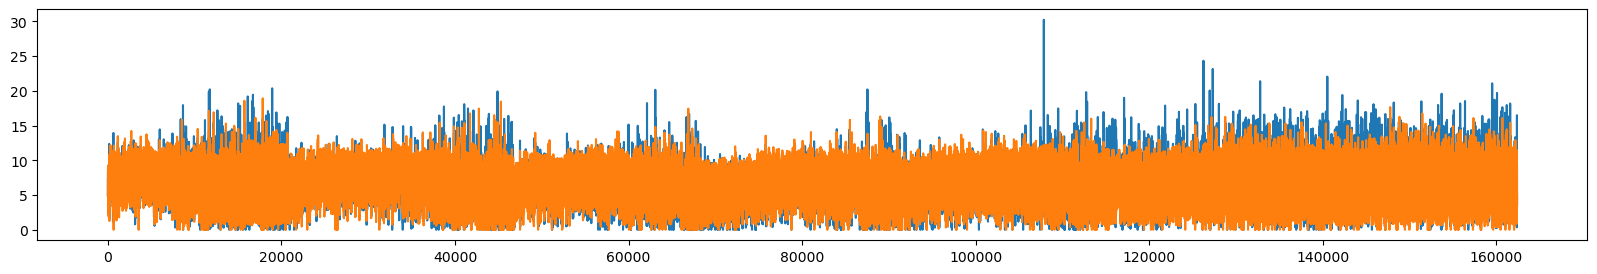

In [34]:
n1= 0
n2 = -1
plt.figure(figsize=(20,3))
plt.plot(df['sat_wspd10n'][n1:n2])
plt.plot(df['buoy_wspd10n'][n1:n2])
np.corrcoef(df['sat_wspd10n'][n1:n2], df['buoy_wspd10n'][n1:n2])[0,1]

In [35]:
# normX['errorFrmNorm'] = np.sqrt(normX['absSpeedDiff']**2 + normX['absDirectionDiff']**2)
# X=normX['errorFrmNorm']

In [36]:
# Y = X.to_numpy()

In [37]:
# Y = np.array([Y]).transpose()
# Y.shape

In [38]:
kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
df['label'] = kmeans.labels_

In [49]:
# def plotTimeSeriesByClusterLabel(df, lat, lon, ax1, ax2, cluster_label=0, color='blue'):
#     subDF = df.loc[df['lat'] == lat]
#     subDF = subDF.loc[subDF['lon'] == lon%360]
#     subDF = subDF.loc[subDF['label'] == cluster_label]

#     if lat < 0:
#         latUnits = 'S'
#         lat = abs(lat)
#     else:
#         latUnits = 'N'

#     if lon < 0:
#         lonUnits = 'W'
#         lon = abs(lon) # 360
#     else:
#         lonUnits = 'E'

    
#     deployFileName = f'../../downloads/Buoy/extractedGZ2/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
#     ds2 = Dataset(deployFileName)
#     startDates = np.array(ds2.variables['startDate'])
#     units = ds2.variables['startDate'].units
#     cftimes = num2date(startDates, units)
#     startDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

#     endDates = np.array(ds2.variables['endDate'])
#     units = ds2.variables['endDate'].units
#     cftimes = num2date(endDates, units)
#     endDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

#     ds2.close()
    
#     cftimes = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')
#     dates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute) for dtm in cftimes])
#     y1 = subDF['speedDiff']
#     y2 = subDF['directionDiff']

#     for i in range(len(startDates)):
#         colorR =list(np.random.choice(range(256), size=3)/256)
        
#         ax1.axvspan(startDates[i], endDates[i], 
#                    alpha=0.05, color=colorR)
#         ax2.axvspan(startDates[i], endDates[i], 
#                    alpha=0.05, color=colorR)
    
#     #ax1.scatter(subDF['time'], y1, s=2, label = cluster_label)#, c = subDF['label'])
#     #ax2.scatter(subDF['time'], y2, s=2, label = cluster_label)#, c = subDF['label'])

#     ax1.scatter(dates, y1, s=3, label = cluster_label, c = color)
#     ax2.scatter(dates, y2, s=3, label = cluster_label, c = color)
#     ax1.set_title(f'{lat:02d}{latUnits} {lon:03d}{lonUnits} speed Diff')
#     ax2.set_title(f'{lat:02d}{latUnits} {lon:03d}{lonUnits} direction Diff')

# def plotTimeSeriesAllClusterLabel(df, lat, lon, ax1, ax2):
#     subDF = df.loc[df['lat'] == lat]
#     subDF = subDF.loc[subDF['lon'] == lon%360]
    
    
#     dates = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')

#     y1 = subDF['speedDiff']
#     y2 = subDF['directionDiff']
    
#     ax1.scatter(subDF['time'], y1, s=2, c = subDF['Deployment Classifier'], cmap='prism')
#     ax2.scatter(subDF['time'], y2, s=2, c = subDF['Deployment Classifier'], cmap='prism')

KeyError: 'Deployment Classifier'

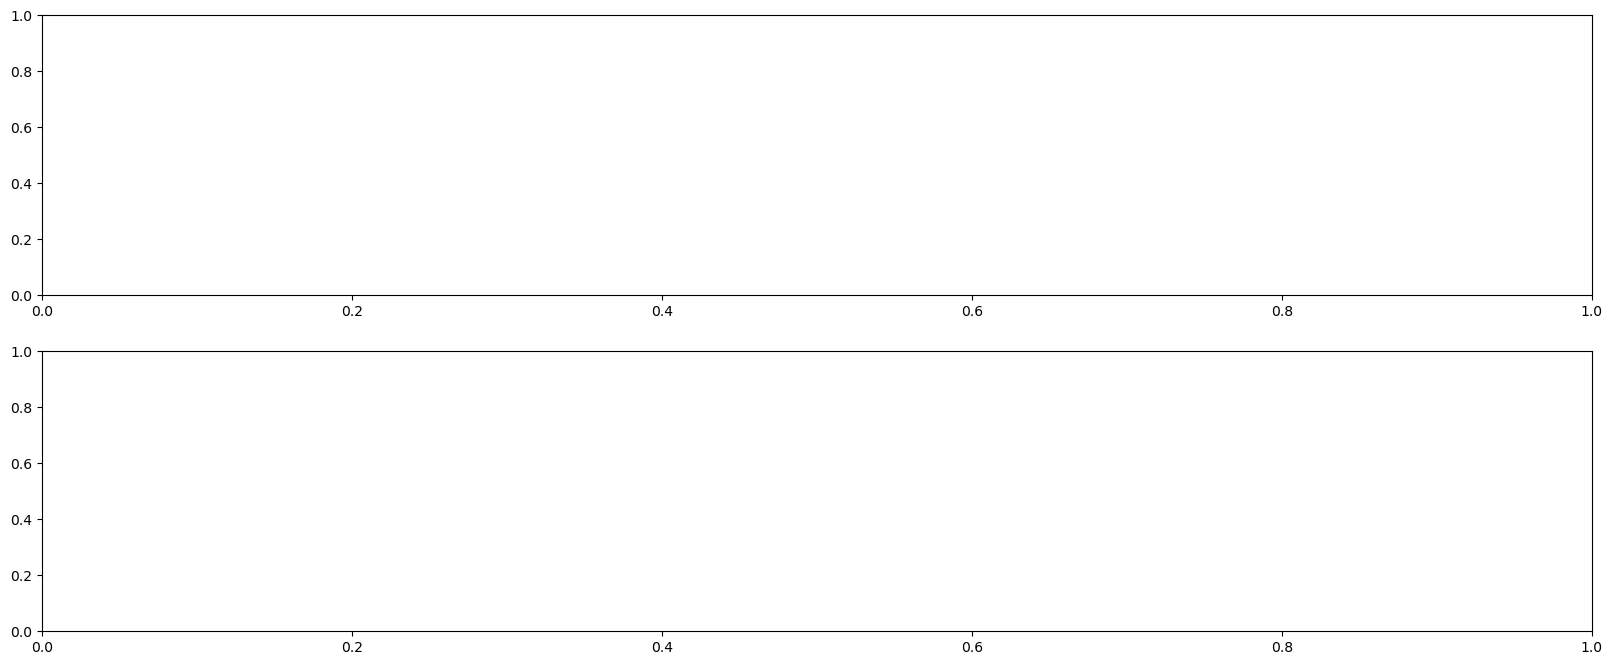

In [50]:
# lat = -2
# lon = -140

# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
# plotTimeSeriesAllClusterLabel(df, lat, lon, axes[0], axes[1])

FileNotFoundError: [Errno 2] No such file or directory: b'../../downloads/Buoy/extractedGZ2/WINDS/T_02S_140W/T_02S_140W_DeploymentDates.nc'

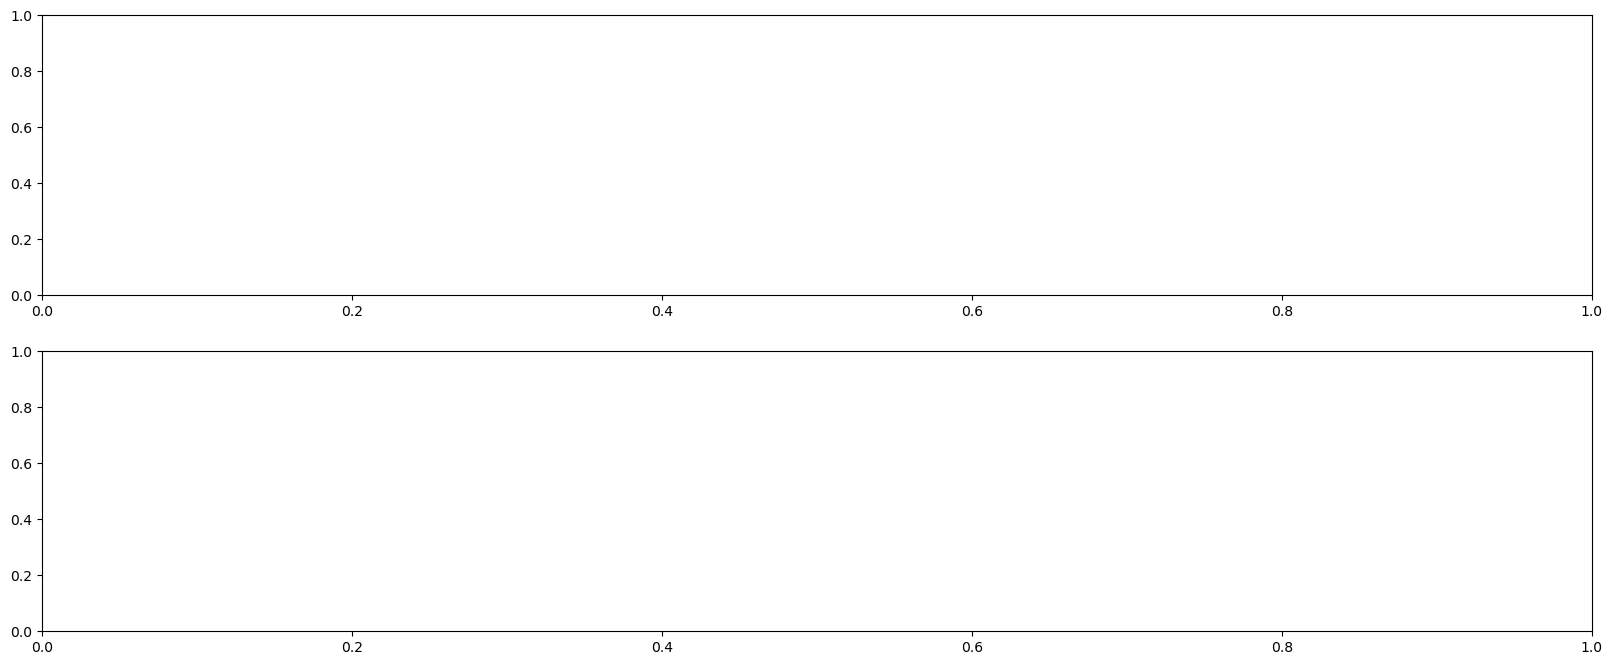

In [51]:
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=0, color = 'blue')
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=1, color = 'green')
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=2, color = 'red')
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=3, color = 'black')
# # plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=4)
# # plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=5)
# # plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=6)
# # plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=7)
# # plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=8)
# # plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=9)
# axes[0].set_ylabel('speed diff.')
# axes[0].legend()

# axes[1].set_ylabel('direction diff.')
# axes[1].legend()

In [52]:
df.head()

,time,lat,lon,sat_wspd10n,sat_u10n,sat_v10n,buoy_wspd10n,buoy_u10n,buoy_v10n,speedDiff,buoy_dir,sat_dir,directionDiff,absDirectionDiff,absSpeedDiff,label
0,734444.17,-8.0,265.0,8.91,-6.166996,6.430883,8.904042,-6.241124,6.350617,0.005958,134.501787,133.800000,-0.701787,0.701787,0.005958,1
1,734444.63,-8.0,265.0,8.10,-6.569617,4.738157,8.701345,-7.154178,4.952893,-0.601345,145.304845,144.199999,-1.104846,1.104846,0.601345,6
2,734446.14,-8.0,265.0,6.89,-5.458876,4.203900,6.463421,-5.289748,3.714078,0.426579,144.926245,142.399999,-2.526246,2.526246,0.426579,1
3,734446.67,-8.0,265.0,6.25,-5.368499,3.200268,7.940334,-7.166975,3.418096,-1.690334,154.502448,149.200001,-5.302448,5.302448,1.690334,0
4,734448.18,-8.0,265.0,8.21,-6.924244,4.411230,7.939315,-7.625445,2.210274,0.270685,163.835501,147.500002,-16.335499,16.335499,0.270685,1


In [13]:
import seaborn as sns

In [54]:
#sns.pairplot(data=df, x = 'hue="label")

In [55]:
# subDFheaders = ['satTimeDiff',
#                  'dist',
#                  'SST_TAO',
#                  'RH_TAO',
#                  'AIRT_TAO',
#                  'speedDiff',
#                  'directionDiff',
#                  'absSpeedDiff',
#                  'absDirectionDiff',
#                  'label']

# subDFheaders = [ 'satTimeDiff',
#                  'dist',
#                  # 'SST_TAO',
#                  # 'RH_TAO',
#                  # 'AIRT_TAO',
#                  'speedDiff',
#                  'directionDiff',
#                  #'absSpeedDiff',
#                  #'absDirectionDiff',
#                  'label']

# subDF = df[subDFheaders]

KeyError: "['satTimeDiff', 'dist'] not in index"

In [23]:
#snsPlot = sns.pairplot(data=subDF, hue="label")

In [24]:
#snsPlot.figure.savefig('allData.png', dpi = 100)

In [25]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=False, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=False, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('allDataProbDensityClusteringJustByErrorsCommonNormFalse.png', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

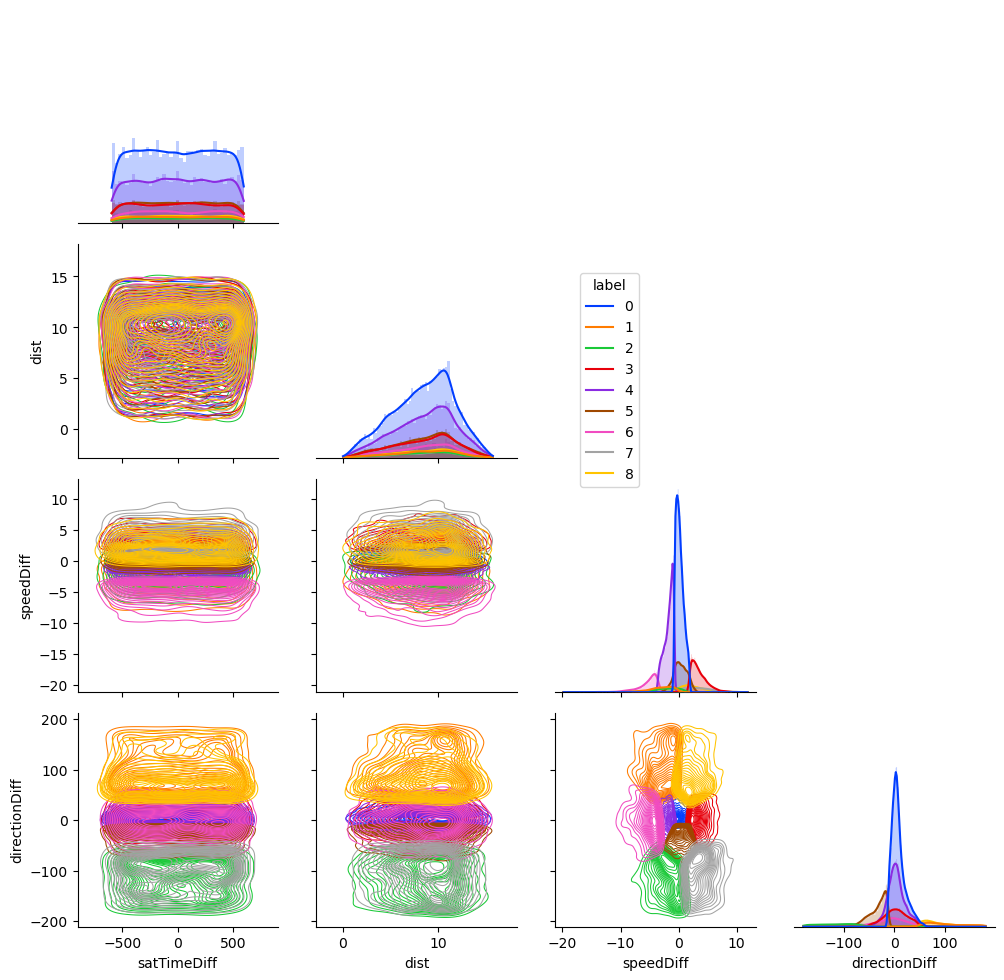

In [26]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=False, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=False, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('timeAndSpaceDistProbDensityClusteringJustByErrorsCommonNormFalse_ASCAT.png', dpi = 100)

In [27]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=True, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=True, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('allDataProbDensityClusteringJustByErrorsCommonNormTrue.png', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

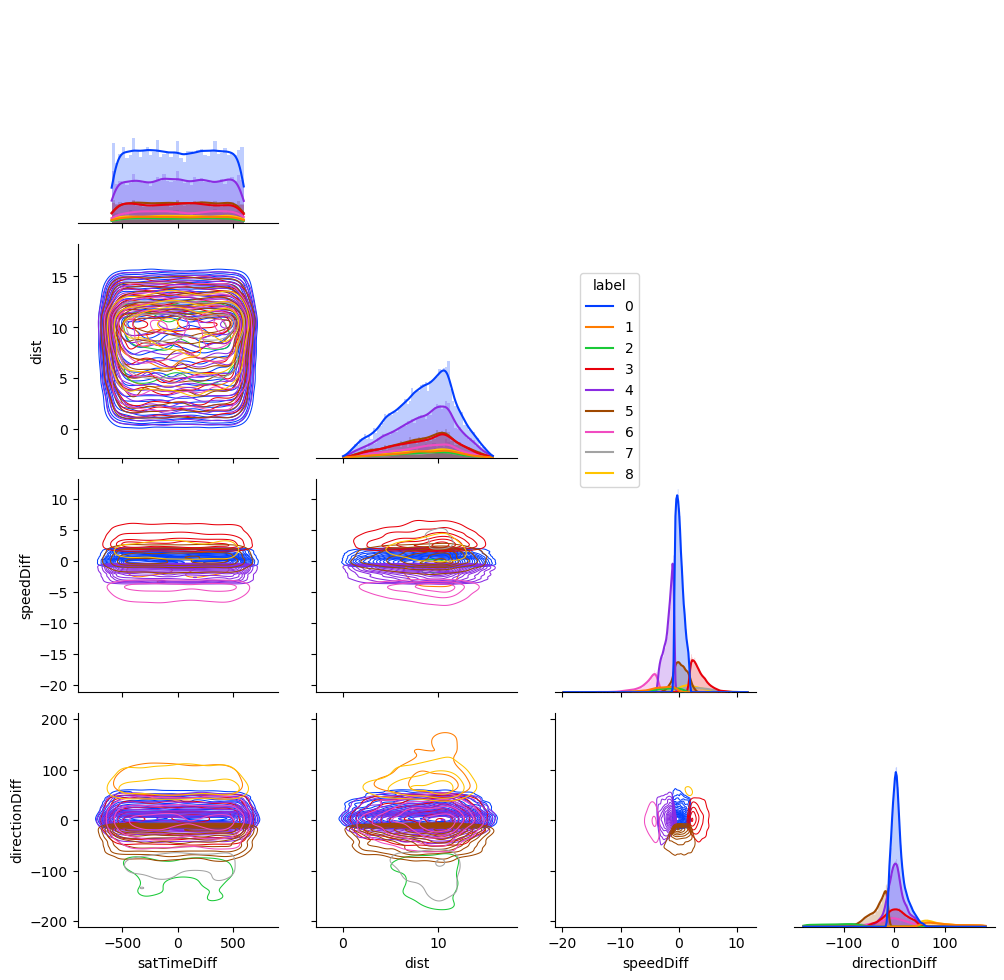

In [28]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=True, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=True, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('timeAndSpaceDistProbDensityClusteringJustByErrorsCommonNormTrue_ASCAT.png', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_66659/3522879587.py:2: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  s = sns.kd

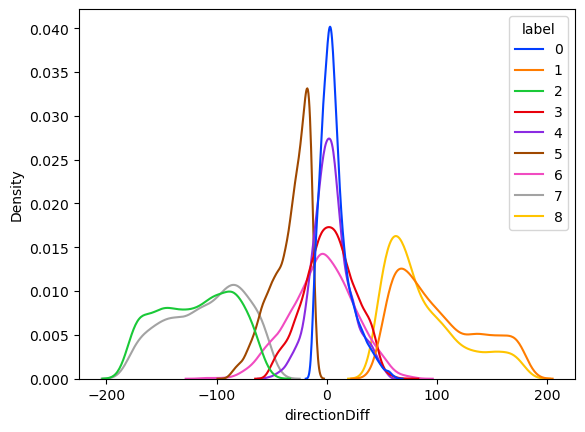

In [29]:
# xlabel = 'directionDiff'
# s = sns.kdeplot(subDF, x=xlabel, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_66659/1776985844.py:2: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  s = sns.kd

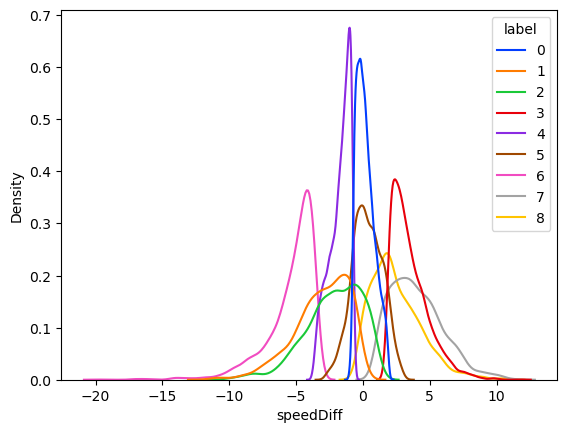

In [30]:
# xlabel = 'speedDiff'
# s = sns.kdeplot(subDF, x=xlabel, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

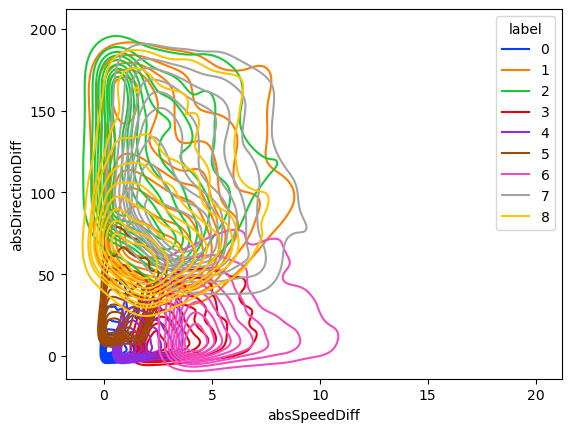

In [31]:
# xlabel = 'absSpeedDiff'
# ylabel = 'absDirectionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

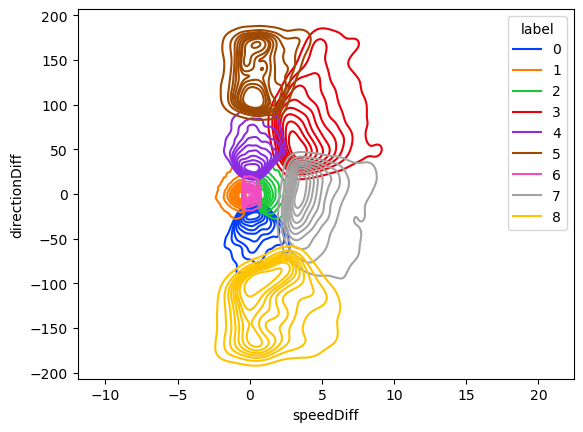

In [39]:
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

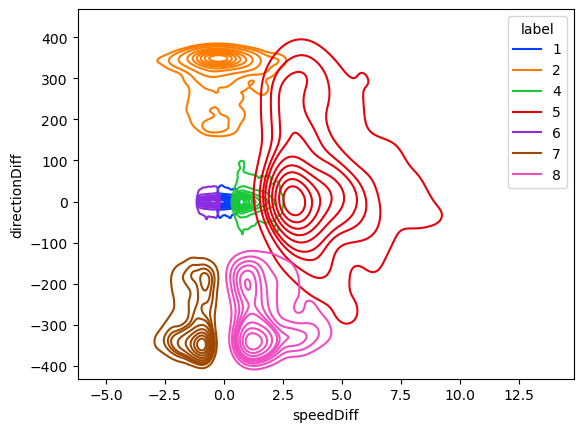

In [71]:
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# subdf = df.loc[df['label'].isin([1,2,4,5,6,7,8])]
# s = sns.kdeplot(subdf, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

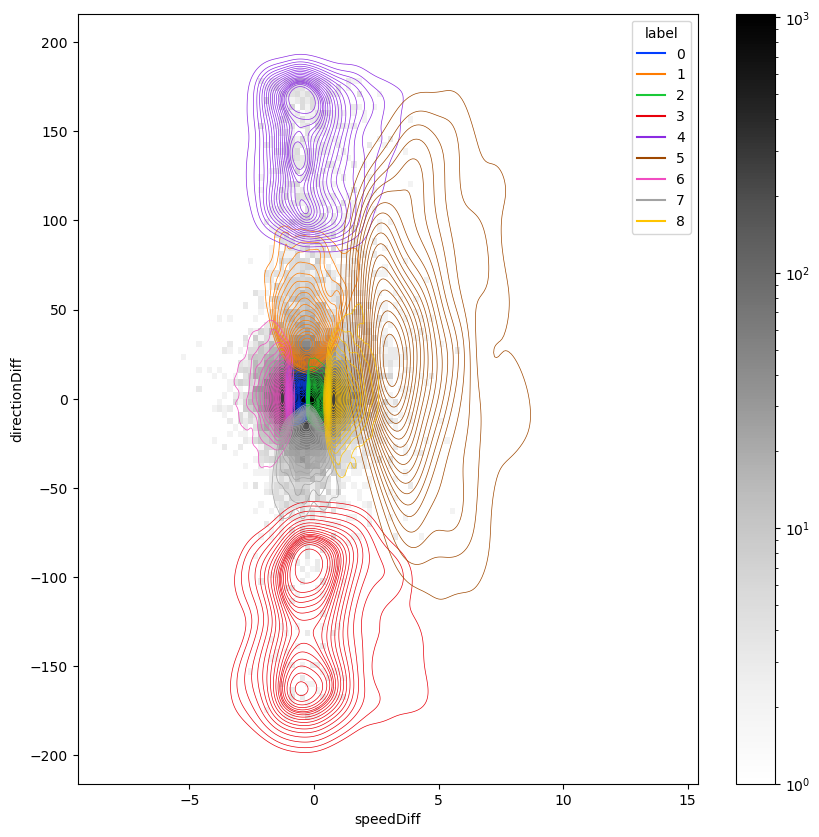

In [84]:
xlabel = 'speedDiff'
ylabel = 'directionDiff'
nx = 100
ny = 100
fig, ax = plt.subplots(figsize=(10,10))
cmap = plt.get_cmap('Greys').copy()
cmap.set_bad('white')

subDF = df #df.loc[df['label'].isin([0,2,3,5])]#,6,8])]

h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                   norm=colors.LogNorm())
s = sns.kdeplot(subDF, x=xlabel, y=ylabel, common_norm=False,
                hue='label',levels=20, linewidths=0.5, 
                palette = sns.color_palette("bright"), ax = ax)

xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()

xrange = (xmax - xmin)
xtol = 0.1 * xrange

yrange = (ymax - ymin)
ytol = 0.1 * yrange

xmin -= xtol
xmax += xtol

ymin -= ytol
ymax += ytol


ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.colorbar(h1[3], ax = ax)

In [ ]:
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', #common_norm=False,
#                 palette = sns.color_palette("bright"))

In [59]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density.png'
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3), sharey=True)
    
    ax = axes[0]
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, 
                    hue='label',levels=20, thres=0.1, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 0]
    ax = axes[1]
    h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[0], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h1[3], ax = ax)
    

    ssubDF = subDF.loc[subDF['label'] == 1]
    ax = axes[2]
    h2 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[1], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h2[3], ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 2]
    ax = axes[3]
    h3 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[2], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h3[3], ax = ax)

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

In [60]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density_errorsOnly_of_each_cluster_ASCAT.png'
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharey=False)
    
    ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, common_norm=False,
                    hue='label',levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange

    yrange = (ymax - ymin)
    ytol = 0.1 * yrange

    xmin -= xtol
    xmax += xtol

    ymin -= ytol
    ymax += ytol


    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    ax.set_xlabel(None)
    
    
    for i in range(1,10):
        ii = int(i//5)
        jj = int(i%5)
        ssubDF = subDF.loc[subDF['label'] == i-1]
        ax = axes[ii, jj]
        h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Greys'), 
                       norm=colors.LogNorm())
        s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                        levels=10, linewidths=0.5, 
                        color = 'Red', ax = ax)
        if ii == 1:
            ax.set_xlabel(xlabel)
        else:
            ax.set_xlabel(None)

        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel(None)
            
        xmin, xmax = ssubDF[xlabel].min(), ssubDF[xlabel].max()
        ymin, ymax = ssubDF[ylabel].min(), ssubDF[ylabel].max()
        
        xrange = (xmax - xmin)
        xtol = 0.1 * xrange
    
        yrange = (ymax - ymin)
        ytol = 0.1 * yrange
    
        xmin -= xtol
        xmax += xtol
    
        ymin -= ytol
        ymax += ytol
        
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title(f'label = {i-1:d}')
        plt.colorbar(h1[3], ax = ax)
    

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

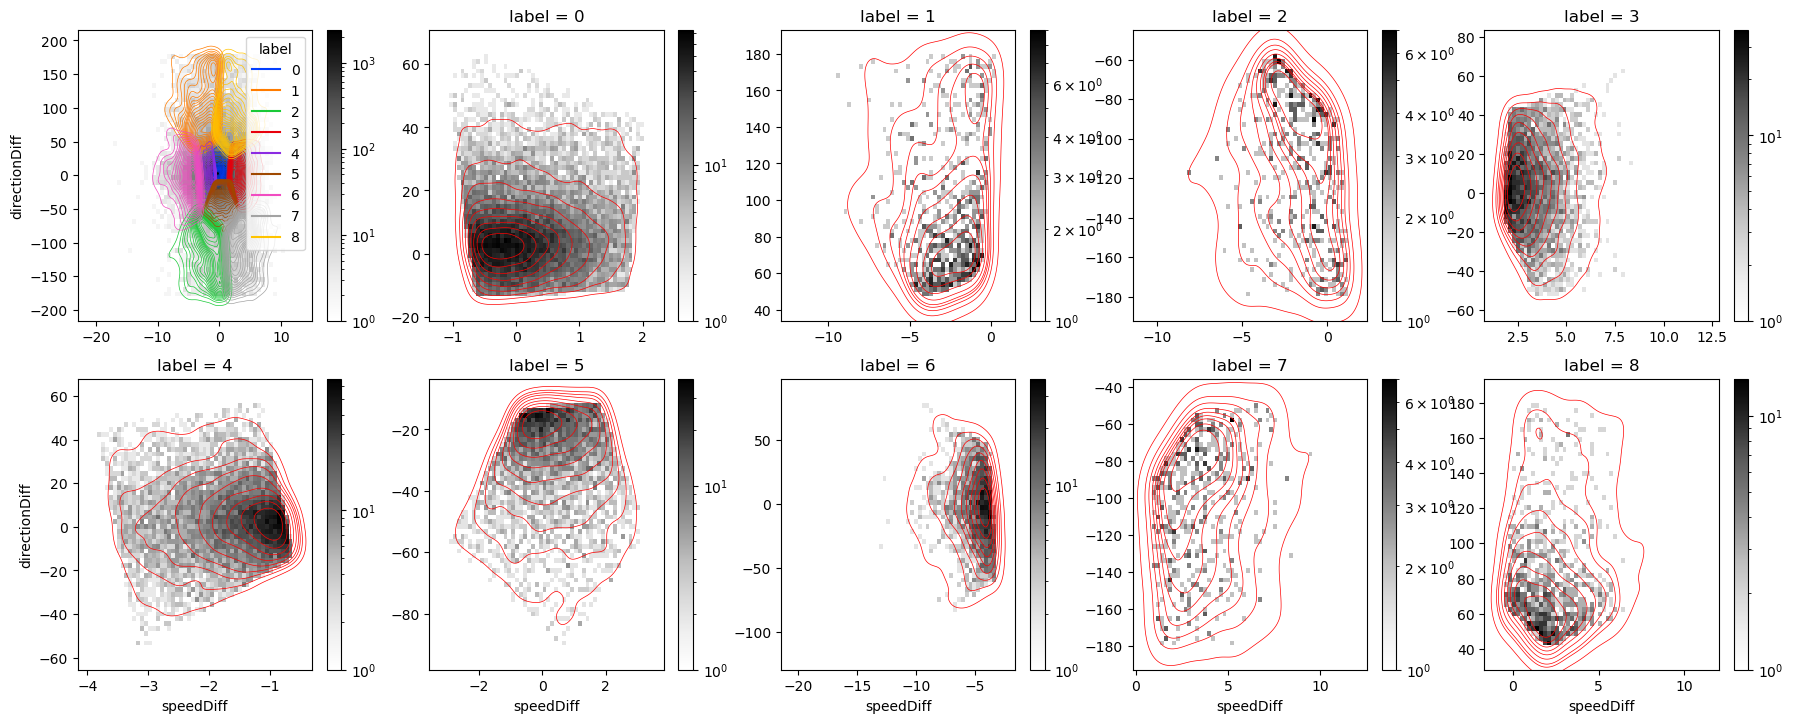

In [37]:
pdfPlotTest('speedDiff', 'directionDiff', df, nx = 50, ny =50)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_62419/3696366440.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mod

Text(0, 0.5, 'directionDiff')

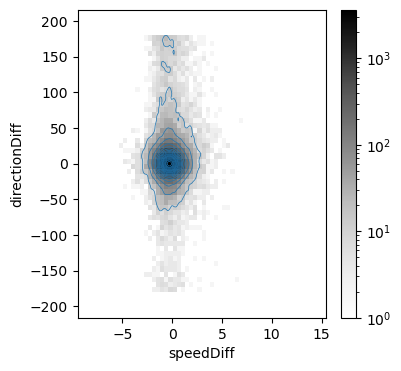

In [85]:
subDF = df
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharey=False)
    
#ax = axes[0,0]
cmap = plt.get_cmap('Greys').copy()
cmap.set_bad('white')
h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
                   norm=colors.LogNorm())
s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
                levels=20, linewidths=0.5, 
                palette = sns.color_palette("bright"), ax = ax)

xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()

xrange = (xmax - xmin)
xtol = 0.1 * xrange

yrange = (ymax - ymin)
ytol = 0.1 * yrange

xmin -= xtol
xmax += xtol

ymin -= ytol
ymax += ytol


ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.colorbar(h1[3], ax = ax)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

In [ ]:
sns.kdeplot(subDF, x='speedDiff', y='directionDiff', 
                    hue='label',levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"))

In [ ]:
for i in range(len(subDFheaders)-1):
    for j in range(i+1, len(subDFheaders)):
        xlabel = subDFheaders[i]
        ylabel = subDFheaders[j]:
        if xlabel != ylabel:
            print(xlabel, ylabel)
            pdfPlotTest(xlabel, ylabel, subDF)

In [ ]:
testDF = df.loc[df['label'] == 1]
testDF.head()

In [ ]:
def pdfPlot1d(subDF, var):
    fname = f'{var}_density.png'
    fig, ax = plt.subplots(figsize=(10,6))
    s = sns.kdeplot(subDF, x=var, hue='label', ax=ax)
    fig.savefig(fname, dpi = 100)
    plt.close()

In [ ]:
for xlabel in subDFheaders:
    print(xlabel)
    pdfPlot1d(subDF, xlabel)

In [ ]:
sns.kdeplot(subDF, x='speedDiff', y='directionDiff', hue='label', levels=20)

In [ ]:
sns.kdeplot(df, x='absSpeedDiff', y='absDirectionDiff', hue='label', levels=20)